In [2]:
# Import required Packages
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import sklearn

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU


In [3]:
import matplotlib.pyplot as plt

In [4]:
data = np.load("/kaggle/input/final-final-t5-train/t5_train.npz")
positive = data["positive"]
negative = data["negative"]

Y_positive = np.ones(positive.shape[0])
Y_negative = np.zeros(negative.shape[0])
X = np.concatenate((positive, negative), axis=0)
Y = np.concatenate((Y_positive, Y_negative), axis=0)
print(X.shape)

(9506, 41, 1024)


In [5]:
X = X[:,5:36,:]
X.shape

(9506, 31, 1024)

In [6]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_t, Y_train, Y_t = train_test_split( X, Y, test_size=0.01, random_state=42)

In [7]:
X = np.vstack((X_train, X_t))
Y = np.vstack((Y_train.reshape(-1,1), Y_t.reshape(-1,1)))
X.shape

(9506, 31, 1024)

In [8]:
test = np.load("/kaggle/input/independent-t5-test/t5_independent_test.npz")
test_neg = test["negative"]
test_pos = test["positive"]
print(test_neg.shape)
print(test_pos.shape)

p_label = np.ones(test_pos.shape[0])
n_label = np.zeros(test_neg.shape[0])
print(p_label.shape)
print(n_label.shape)

X_test_all = np.vstack([test_pos, test_neg])
Y_test_all = np.vstack([p_label.reshape(-1,1), n_label.reshape(-1,1)])

(2973, 31, 1024)
(253, 31, 1024)
(253,)
(2973,)


In [16]:
# Function to get_score from the model given the training and test dataset

def get_score(model, X_train, X_test, y_train, y_test):
    # patient early stopping

    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
    # history = model.fit(X_train, y_train, epochs=20, validation_data = (X_test, y_test), verbose=0, callbacks=[es])
    
    history = model.fit(X_train, y_train, epochs=30, batch_size = 1024*2, validation_data = (X_test, y_test), verbose=0)

    X_shape = X_train.shape
  
        
  # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    y_prediction = model.predict(X_test) > 0.45
    y_prediction = np.where(y_prediction > 0.45, 1, 0)
    mcc =sklearn.metrics.matthews_corrcoef(y_test, y_prediction)
    print('mcc:', mcc)
    return train_acc, test_acc, history

In [17]:

def build_model():
  model = models.Sequential()
  model.add(layers.Conv1D(filters = 256, kernel_size = 1, activation='relu', input_shape= (31, 1024), padding="same"))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(filters = 128, kernel_size = 1, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  return model

In [19]:
def compile_model(model):
    model.compile(optimizer='adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model


30/30 [==============================] - 0s 10ms/step
mcc: 0.48837452667589687
-----------------------------------------------
0.9171245098114014 0.742376446723938
-----------------------------------------------
101/101 [==============================] - 1s 9ms/step
Confusion Matrix: 
 [[2156  817]
 [  57  196]]
0.2895628118626313
-----------------------------------------------
30/30 [==============================] - 0s 8ms/step
mcc: 0.4610226452124321
-----------------------------------------------
0.9228521585464478 0.7350157499313354
-----------------------------------------------
101/101 [==============================] - 1s 9ms/step
Confusion Matrix: 
 [[2178  795]
 [  65  188]]
0.2778291904288517
-----------------------------------------------
30/30 [==============================] - 0s 8ms/step
mcc: 0.5672542183004948
-----------------------------------------------
0.9123319983482361 0.7676130533218384
-----------------------------------------------
101/101 [===================

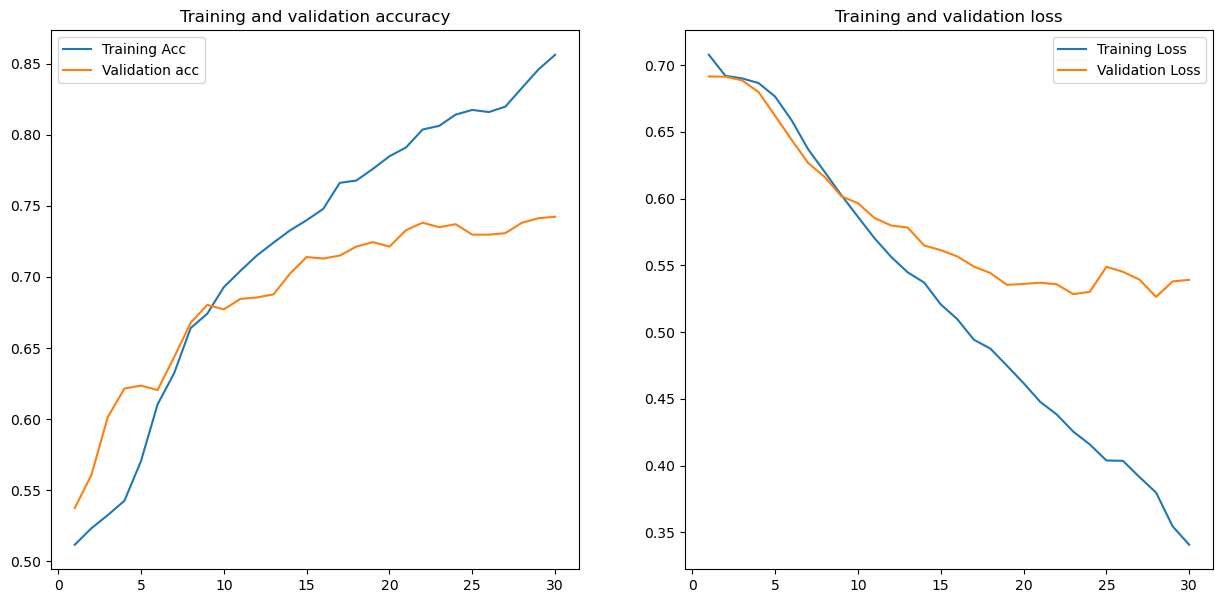

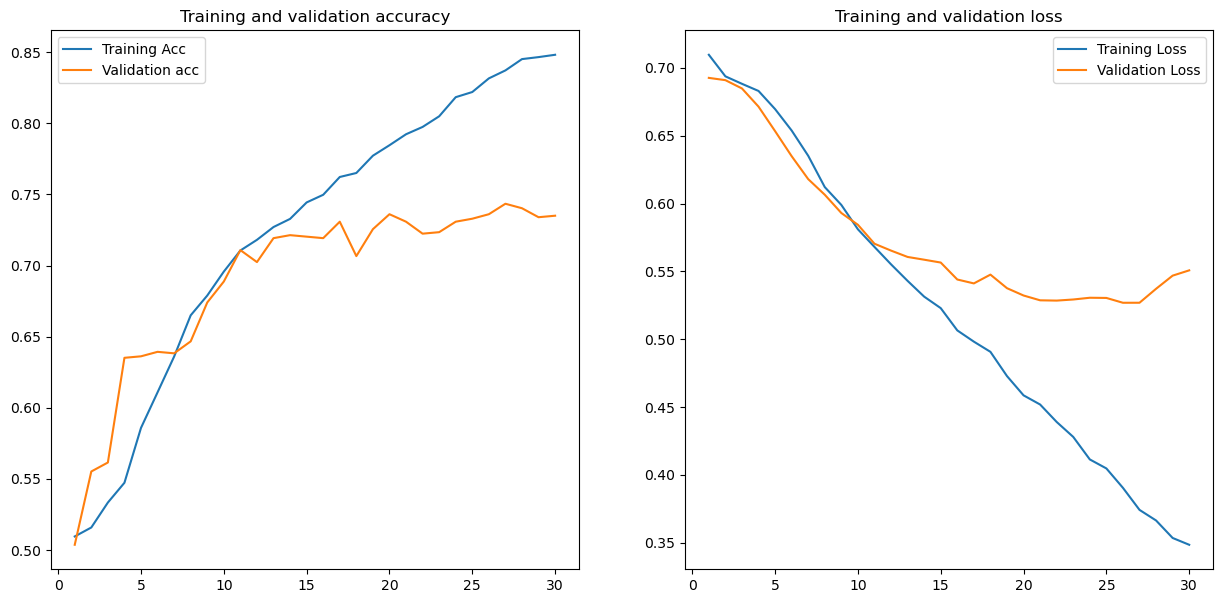

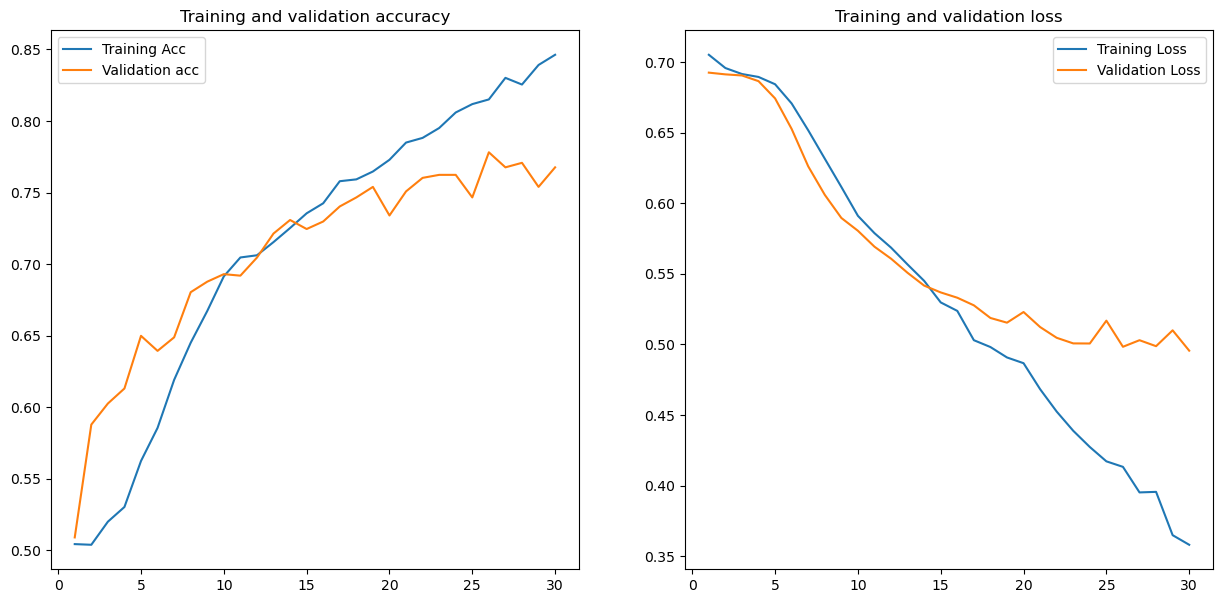

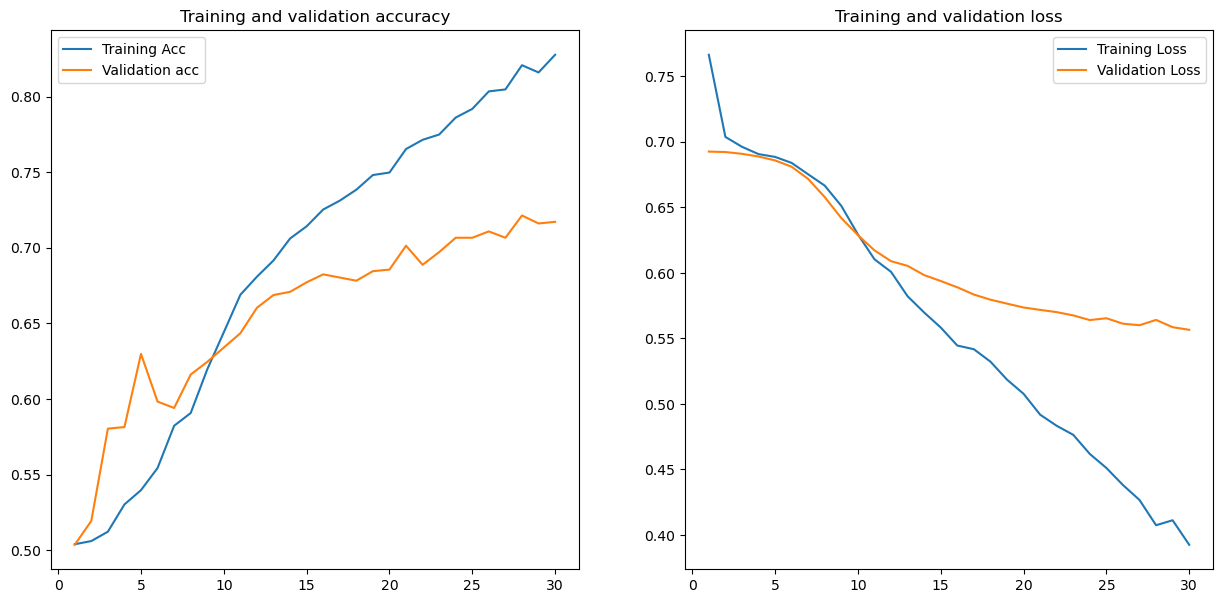

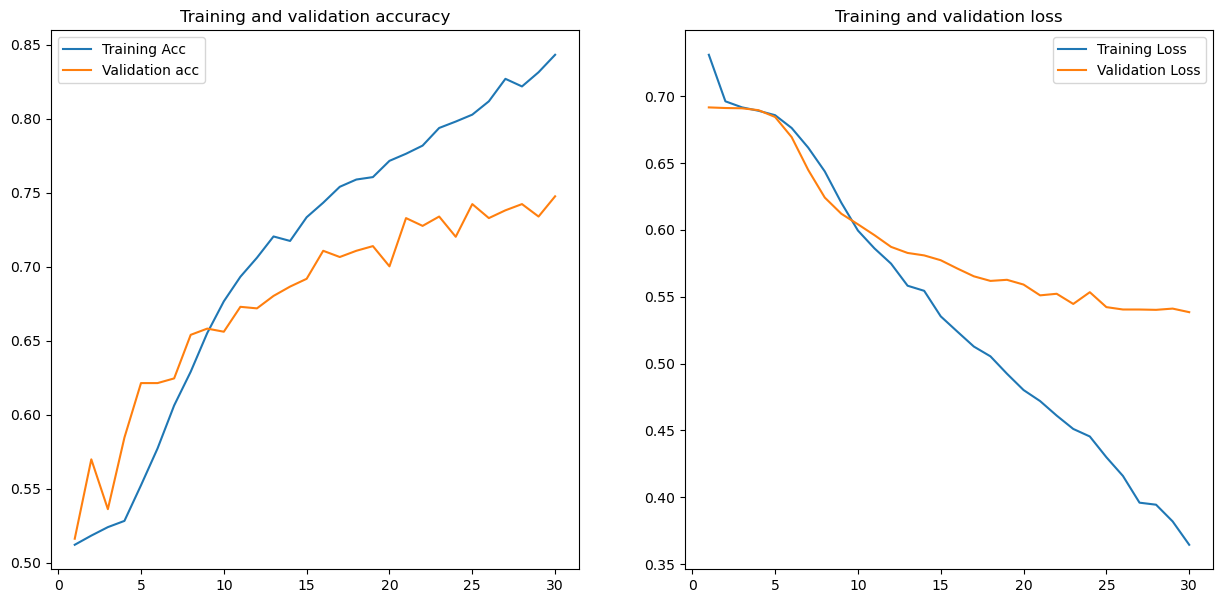

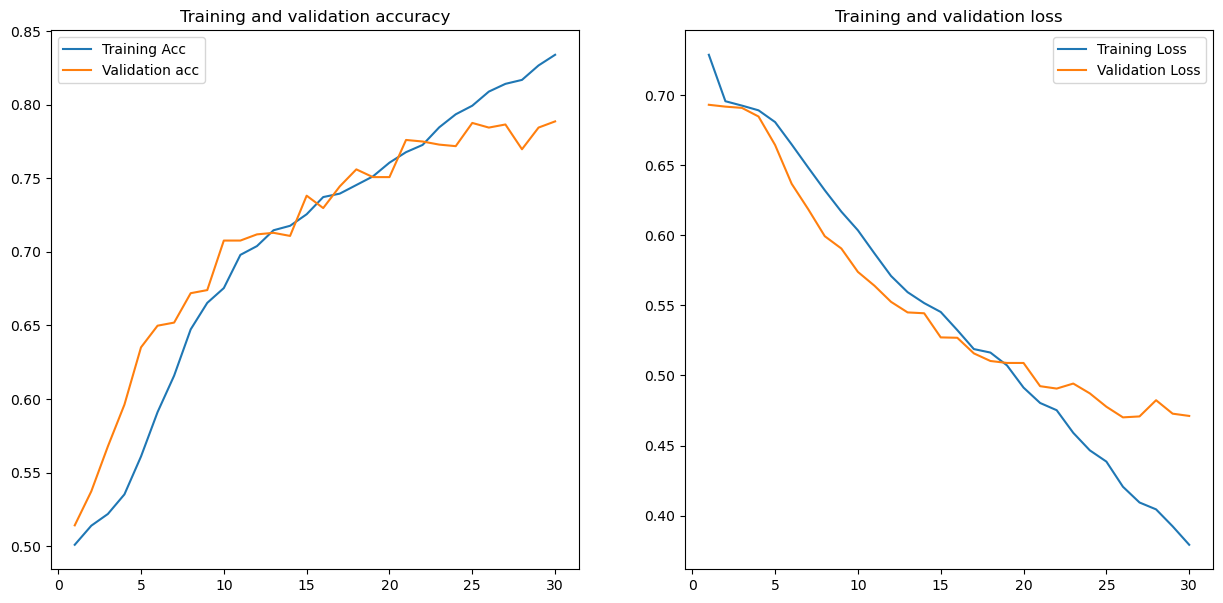

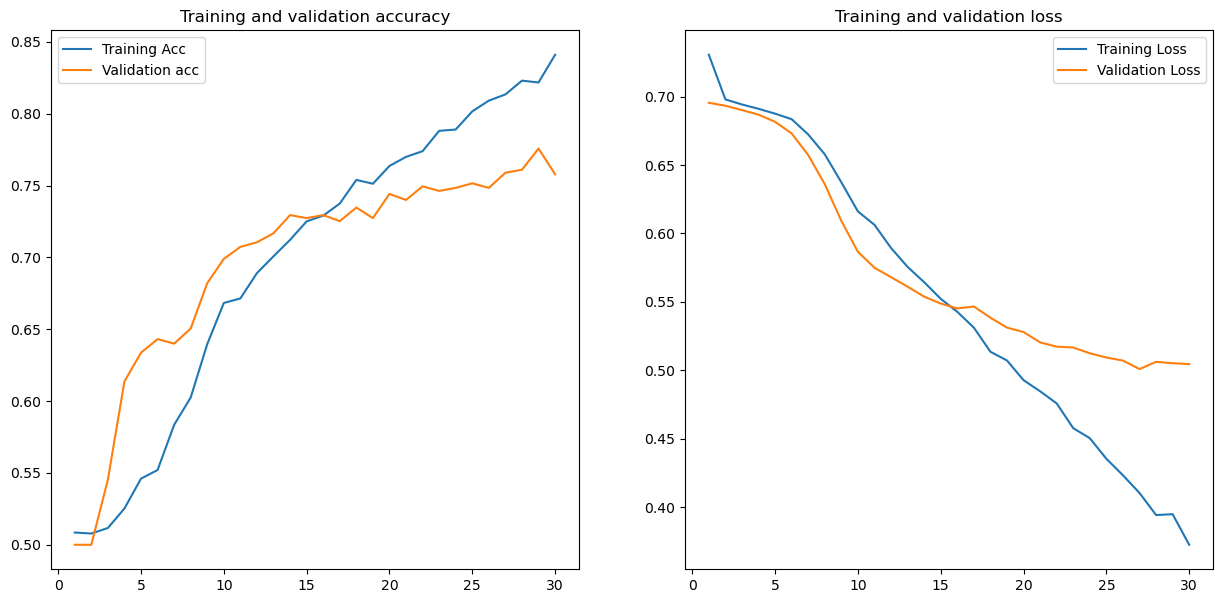

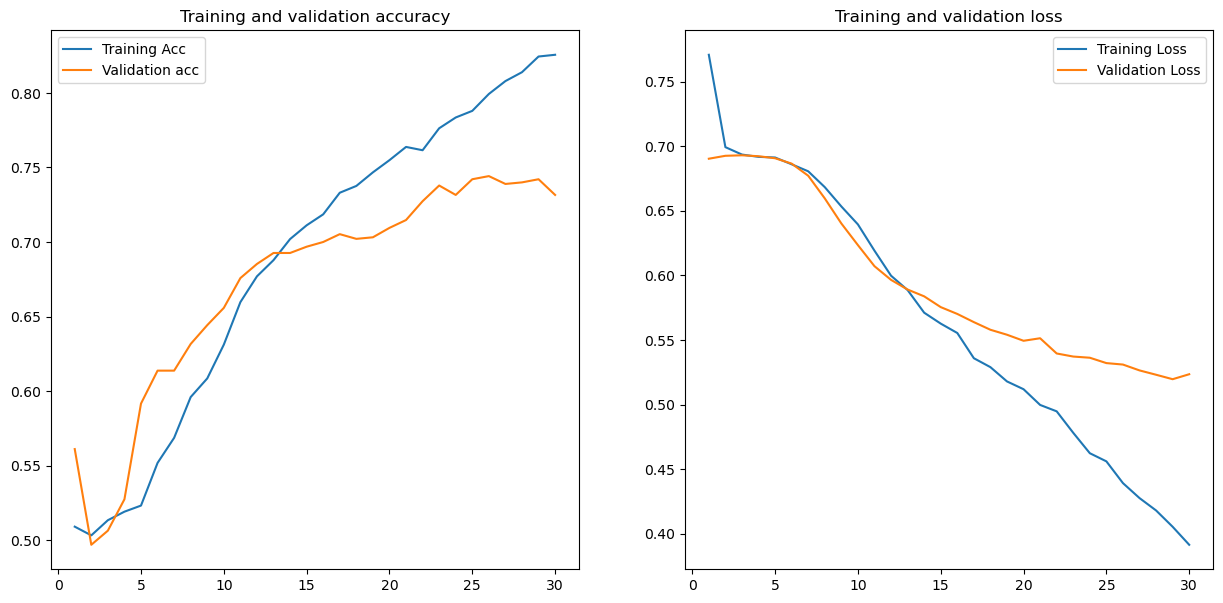

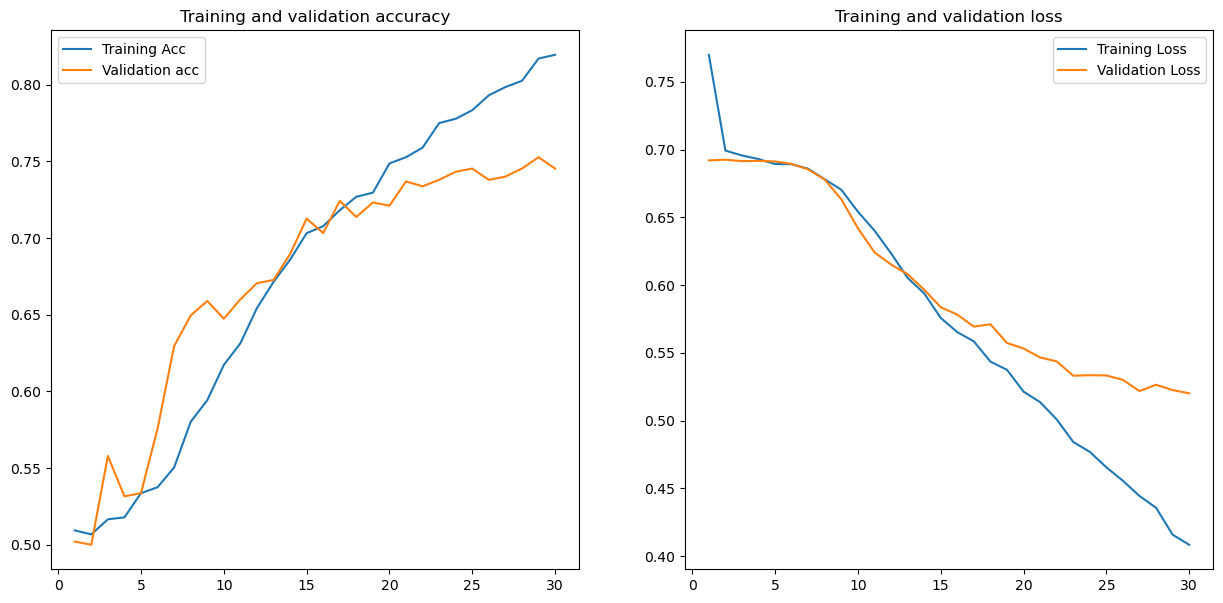

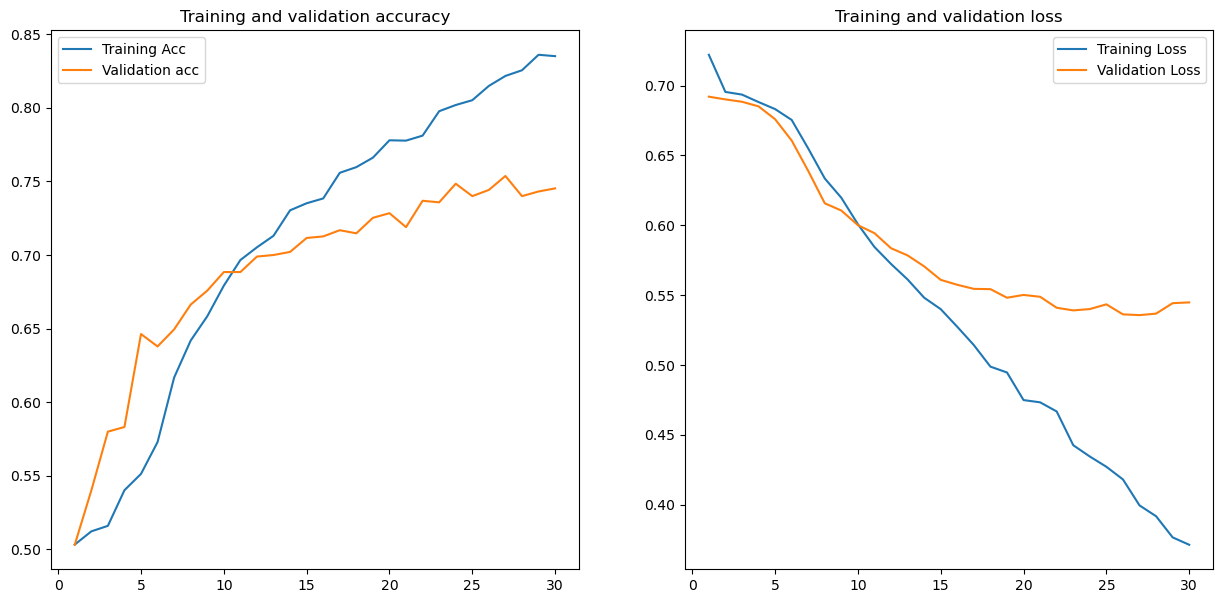

In [20]:
folds = StratifiedKFold(n_splits=10)
scores = {}
scores['train_acc'] = []
scores['val_acc'] = []
max_test_mcc = 0
max_val_acc = 0
# X = X_train
# Y = Y_train
mcc_hist = []
acc_hist = []
conf_mat_hist = []
f1_s_hist = []
for train_index, test_index in folds.split(X,Y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], \
                                    Y[train_index], Y[test_index]
    model = build_model()
    model = compile_model(model)
    train_acc, val_acc, history = get_score(model, X_train, X_test, y_train, y_test)
    print('-----------------------------------------------')
    print(train_acc, val_acc)
    print('-----------------------------------------------')  
    y_prediction = model.predict(X_test_all)
    y_prediction = np.where(y_prediction > 0.4, 1, 0)
    result = confusion_matrix(Y_test_all, y_prediction)
    print("Confusion Matrix: \n",result)
    mcc =sklearn.metrics.matthews_corrcoef(Y_test_all, y_prediction)
    print(mcc)
    print('-----------------------------------------------')
    train_acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']

    epochs = range(1, len(train_acc_history) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    ax1.plot(epochs, train_acc_history, label='Training Acc')
    ax1.plot(epochs, val_acc_history, label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.legend()
    ax2.plot(epochs, loss_history, label='Training Loss')
    ax2.plot(epochs, val_loss_history, label='Validation Loss')
    ax2.set_title('Training and validation loss')
    ax2.legend()
    
    mcc_hist.append(mcc)
    if mcc > max_test_mcc:
        model.save('/kaggle/working/bert_win31_mcc.h5')
        max_test_mcc = mcc
    scores['train_acc'].append(train_acc)
    scores['val_acc'].append(val_acc)

In [21]:
print(np.mean(mcc_hist))
print(np.std(mcc_hist))

# print(np.mean(acc_hist))
# print(np.std(acc_hist))

0.26667840941072135
0.018494180396129007


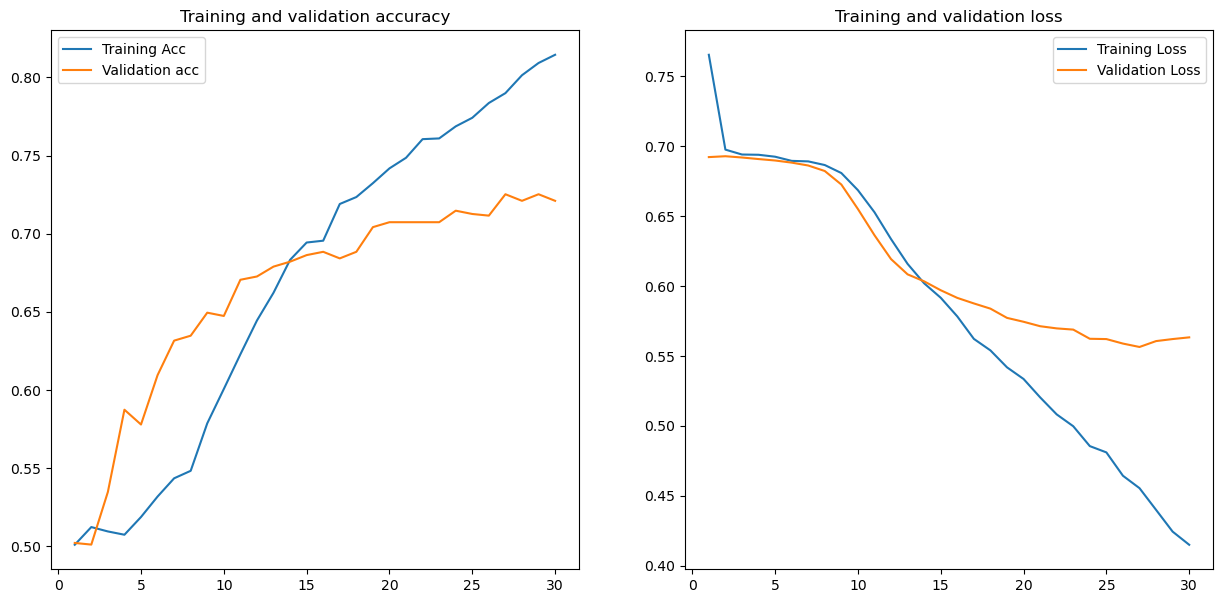

In [108]:
train_acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

epochs = range(1, len(train_acc_history) + 1)
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
ax1.plot(epochs, train_acc_history, label='Training Acc')
ax1.plot(epochs, val_acc_history, label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()
ax2.plot(epochs, loss_history, label='Training Loss')
ax2.plot(epochs, val_loss_history, label='Validation Loss')
ax2.set_title('Training and validation loss')
ax2.legend()

fig.savefig('xyz.jpg')

In [ ]:
# model.save('/kaggle/working/model6412864w21.h5')

In [13]:
from tensorflow.keras.models import load_model
new_model = load_model("/kaggle/working/bert_win31_mcc.h5")
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 31, 144)           147600    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 144)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 144)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 128)           18560     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 128)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 128)            0

In [73]:
test = np.load("/kaggle/input/independent-t5-test/t5_independent_test.npz")
test_neg = test["negative"]
test_pos = test["positive"]
print(test_neg.shape)
print(test_pos.shape)

p_label = np.ones(test_pos.shape[0])
n_label = np.zeros(test_neg.shape[0])
print(p_label.shape)
print(n_label.shape)

X_test_all = np.vstack([test_pos, test_neg])
Y_test_all = np.vstack([p_label.reshape(-1,1), n_label.reshape(-1,1)])

(2973, 31, 1024)
(253, 31, 1024)


(253,)
(2973,)


In [82]:
#Predict


101/101 [==============================] - 1s 6ms/step
Confusion Matrix: 
 [[2079  894]
 [  50  203]]
0.28469545411620684


In [77]:
print("Confusion Matrix: \n",result)


Confusion Matrix: 
 [[2079  894]
 [  50  203]]


In [78]:
import sklearn
y_pred = model.predict(X_test_all) > 0.5
mcc =sklearn.metrics.matthews_corrcoef(Y_test_all, y_prediction)
print(mcc)

101/101 [==============================] - 1s 6ms/step
0.28469545411620684


In [79]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test_all, y_prediction)
print(accuracy)

0.7073775573465592


In [80]:
result = f1_score(Y_test_all, y_prediction)
print("F1_score: \n",result)

F1_score: 
 0.3007407407407407


# 